# Heart Disease Prediction using Machine Learning

**Course:** Machine learing 
**Student:** Hassan Eldeeb
**ID:** CU2201452
**Instructor:** dr batoul

This project focuses on predicting heart disease using machine learning classification techniques on a real-world Kaggle dataset.

## 1. Problem Definition

Describe heart disease, why it is important, and why machine learning can help.
- Type of problem: Supervised Classification
- Target variable: Presence or absence of heart disease

Problem: Cardiovascular diseases (CVDs) are the number one cause of death globally. Early detection is crucial for management. Objective: The goal is to build a classification model to predict the presence or absence of cardiovascular disease (cardio = 1 or 0) based on objective, examination, and subjective features. Type: Supervised Binary Classification.

## 2. Dataset Description (Kaggle)

- Dataset name:
- Dataset link:
- Number of rows:
- Number of columns:
- Description of each feature:
- Target column:

## 3. Environment Setup

List all Python libraries that will be used in this project.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set plot style
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

## 4. Data Loading



age: Age in days (needs conversion)

gender: 1 = Women, 2 = Men

height: Height in cm

weight: Weight in kg

ap_hi: Systolic blood pressure

ap_lo: Diastolic blood pressure

cholesterol: 1: normal, 2: above normal, 3: well above normal

gluc: 1: normal, 2: above normal, 3: well above normal

smoke: Smoking (binary)

alco: Alcohol intake (binary)

active: Physical activity (binary)

cardio: Target variable (1: disease present, 0: absent)

In [3]:
# Load the dataset (Note the separator is ';')
df = pd.read_csv('cardio_train.csv', sep=';')

# Drop the 'id' column as it's not useful for prediction
df.drop('id', axis=1, inplace=True)

# Display basic info
print(f"Dataset Shape: {df.shape}")
print("\nDataset Info:")
print(df.info())

# Show first 5 rows
df.head()

Dataset Shape: (70000, 12)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.4 MB
None


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Exploratory Data Analysis (EDA)

In [4]:
print(df['cardio'].value_counts())

cardio
0    35021
1    34979
Name: count, dtype: int64


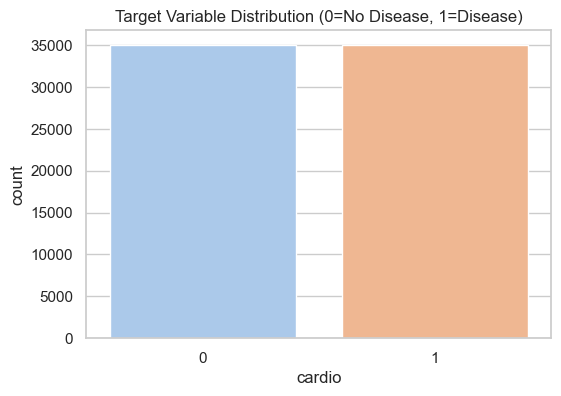

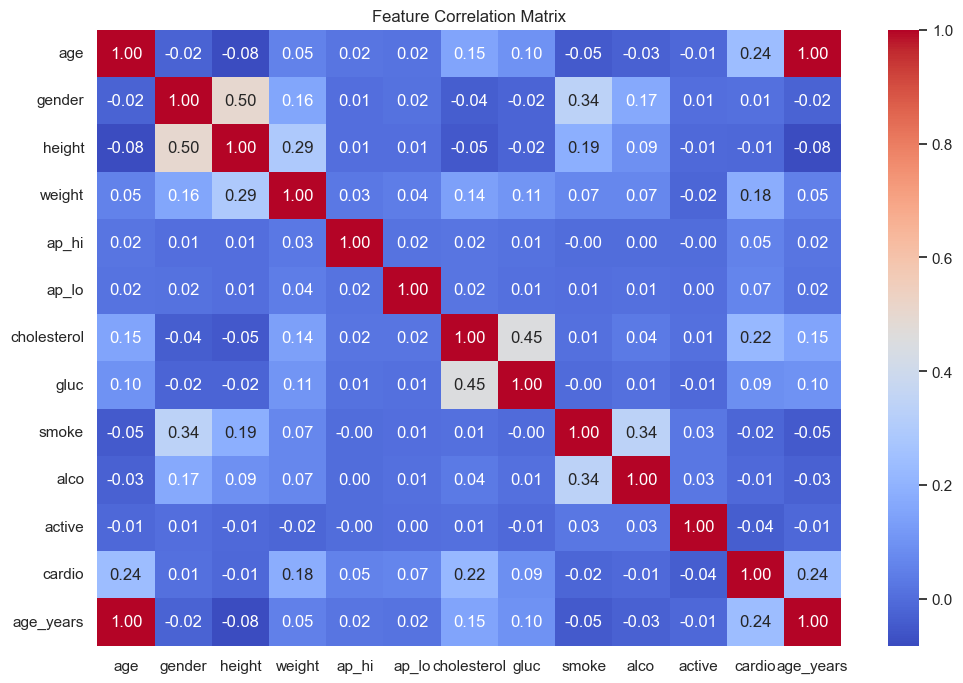

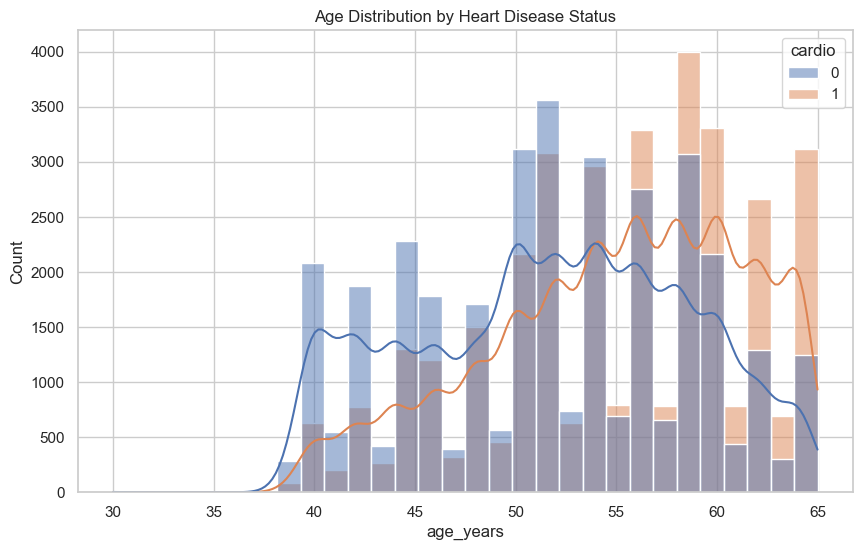

In [5]:
# 1. Convert Age from days to years for better visualization
df['age_years'] = (df['age'] / 364.8).round().astype(int)

# 2. Check Class Balance
plt.figure(figsize=(6, 4))
sns.countplot(x='cardio', data=df, palette='pastel')
plt.title('Target Variable Distribution (0=No Disease, 1=Disease)')
plt.show()

# 3. Correlation Matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

# 4. Age Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='age_years', hue='cardio', kde=True, bins=30)
plt.title('Age Distribution by Heart Disease Status')
plt.show()

## 5. Data Cleaning, Preprocessing, and Feature Engineering

Describe:
- Handling missing values
- Removing duplicates
- Feature encoding
- Scaling
- Any transformations applied
- Applying kmeans to create new variable

In [6]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans

# 2. Basic Sanity Check (Crucial before Scaling)
# We remove absolute impossibilities (like negative blood pressure) so they don't skew the StandardScaler mean/std.
df = df[(df['ap_hi'] > 20) & (df['ap_hi'] < 300)]
df = df[(df['ap_lo'] > 20) & (df['ap_lo'] < 200)]

# 3. Label Encoding for Categorical Variables
# (gender, cholesterol, gluc, smoke, alco, active)
categorical_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
le = LabelEncoder()

for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("\nCategorical Columns after Encoding:")
print(df[categorical_cols].head())

numeric_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
scaler = StandardScaler()

df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
print("\nNumeric Columns after Scaling:")
print(df[numeric_cols].head())

# 5. Isolation Forest for Outlier Removal
# We assume approx 5% of the data might be anomalous
iso = IsolationForest(contamination=0.05, random_state=42)
y_outliers = iso.fit_predict(df.drop('cardio', axis=1))

# Select only the rows where prediction is 1 (Inliers). -1 are outliers.
df_clean = df[y_outliers == 1].copy()

print(f"Original shape: {df.shape}")
print(f"Shape after Isolation Forest: {df_clean.shape}")
print(f"Dropped {df.shape[0] - df_clean.shape[0]} anomalous rows.")

# 6. KMeans Clustering
# Create a new feature 'cluster_label'
kmeans = KMeans(n_clusters=3, random_state=42)
df_clean['cluster_label'] = kmeans.fit_predict(df_clean.drop('cardio', axis=1))

print("\nNew feature 'cluster_label' created.")

# 7. Final Train-Test Split
X = df_clean.drop('cardio', axis=1)
y = df_clean['cardio']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nFinal Training Set Shape: {X_train.shape}")
print(f"Final Test Set Shape: {X_test.shape}")

# Preview the new data
X_train.head()




Categorical Columns after Encoding:
   gender  cholesterol  gluc  smoke  alco  active
0       1            0     0      0     0       1
1       0            2     0      0     0       1
2       0            2     0      0     0       0
3       1            0     0      0     0       1
4       0            0     0      0     0       0

Numeric Columns after Scaling:
        age    height    weight     ap_hi     ap_lo
0 -0.434143  0.444513 -0.845921 -0.991163 -0.142188
1  0.309357 -1.021593  0.758977  0.798448  0.889986
2 -0.246141  0.077987 -0.706365  0.201911 -1.174362
3 -0.746130  0.566688  0.549642  1.394985  1.922160
4 -0.806501 -1.021593 -1.264590 -1.587700 -2.206536
Original shape: (68781, 13)
Shape after Isolation Forest: (65342, 13)
Dropped 3439 anomalous rows.

New feature 'cluster_label' created.

Final Training Set Shape: (52273, 13)
Final Test Set Shape: (13069, 13)


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,cluster_label
65770,-0.219805,0,-0.899417,-1.613481,-0.394626,-0.142188,0,0,0,0,1,52,0
69932,-1.710451,1,0.811039,-0.497030,-0.991163,-2.206536,0,0,0,0,1,42,2
52376,0.887139,0,-0.777242,-0.497030,0.798448,0.889986,2,2,0,0,1,59,1
27466,-0.503429,0,-0.899417,1.945206,-0.394626,-0.142188,0,0,0,0,1,50,0
64157,0.638361,0,1.910618,0.758977,1.394985,0.889986,0,2,0,0,1,58,1


## 11. Training Multiple Machine Learning Models

List and describe all machine learning models used for classification.

In [9]:
from sklearn.svm import SVC
ForestModel=RandomForestClassifier(n_estimators=100, random_state=42)
KNNModel=KNeighborsClassifier(n_neighbors=5)
SVCModel=SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
models = {
    'Random Forest': ForestModel,
    'K-Nearest Neighbors': KNNModel,
    'Support Vector Machine': SVCModel
}
for model_name, model in models.items():
    model.fit(X_train, y_train)

## 12. Model Evaluation and Comparison

Explain:
- Accuracy
- Precision
- Recall
- F1-Score
- Confusion Matrix

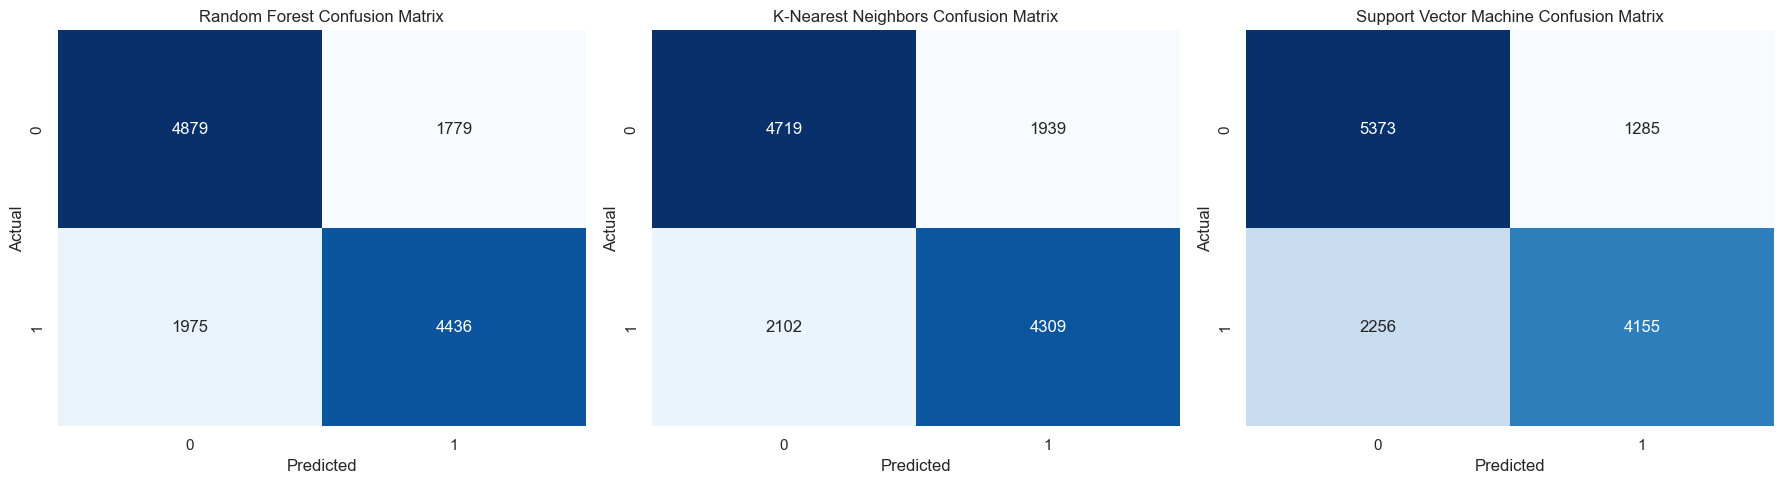


--- Model Performance Comparison ---


,Accuracy,Precision,Recall,F1-Score
Model,,,,
Random Forest,0.712755,0.713757,0.691936,0.702677
K-Nearest Neighbors,0.690795,0.689661,0.672126,0.680780
Support Vector Machine,0.729053,0.763787,0.648105,0.701207



Detailed Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      6658
           1       0.71      0.69      0.70      6411

    accuracy                           0.71     13069
   macro avg       0.71      0.71      0.71     13069
weighted avg       0.71      0.71      0.71     13069


Detailed Classification Report for K-Nearest Neighbors:
              precision    recall  f1-score   support

           0       0.69      0.71      0.70      6658
           1       0.69      0.67      0.68      6411

    accuracy                           0.69     13069
   macro avg       0.69      0.69      0.69     13069
weighted avg       0.69      0.69      0.69     13069


Detailed Classification Report for Support Vector Machine:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75      6658
           1       0.76      0.65      0.70      6411

    accuracy  

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

results = []

# 2. Loop through models and evaluate
plt.figure(figsize=(18, 5)) # Adjust size for side-by-side plots

for i, (name, model) in enumerate(models.items()):
    # Predict
    y_pred = model.predict(X_test)
    
    # Calculate Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1-Score": f1
    })
    
    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.subplot(1, 3, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

# 3. Display Comparison Table
results_df = pd.DataFrame(results)
results_df.set_index('Model', inplace=True)

print("\n--- Model Performance Comparison ---")
display(results_df.style.highlight_max(axis=0, color='lightgreen'))

# 4. Detailed Report for the Best Model (usually RF or SVM)
# We can just print the classification report for all of them to be thorough
for name, model in models.items():
    print(f"\nDetailed Classification Report for {name}:")
    print(classification_report(y_test, model.predict(X_test)))

## 13. Hyperparameter Tuning

Explain the tuning process using GridSearchCV or RandomSearch.

In [15]:
# --- 13. Hyperparameter Tuning (All Models) ---
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import pandas as pd
import time

# Dictionary defining the models and their parameter grids
# n_jobs=-1 tells the computer to use ALL CPU cores for parallel processing
model_params = {

    "K-Nearest Neighbors": {
        "model": KNeighborsClassifier(),
        "params": {
            "n_neighbors": [5, 9, 15, 20],
            "weights": ["uniform", "distance"],
            "metric": ["euclidean", "manhattan"]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 10]
        }
    },
    # SVM is extremely slow. We will tune it, but handle it carefully.
    "Support Vector Machine": {
        "model": SVC(random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["rbf"],  # 'poly' is often too slow for this size
            "gamma": ["scale", "auto"]
        }
    }
}

best_estimators = {}
tuning_results = []

print("Starting Parallel Hyperparameter Tuning...")
print("------------------------------------------------")

for model_name, mp in model_params.items():
    print(f"Tuning {model_name}...")
    start_time = time.time()
    
    # SPECIAL HANDLING FOR SVM:
    # SVM takes O(n^3) time. Tuning on 60k rows can take days.
    # We will tune on a subset (first 5000 rows) to get parameters, 
    # then apply those parameters to the full model.
    if model_name == "Support Vector Machine":
        print("  > SVM detected: Tuning on subset (5000 rows) to save time...")
        X_tune = X_train[:5000]
        y_tune = y_train[:5000]
    else:
        X_tune = X_train
        y_tune = y_train

    # Initialize GridSearchCV
    clf = GridSearchCV(mp['model'], mp['params'], cv=3, n_jobs=-1, verbose=1)
    
    # Fit
    clf.fit(X_tune, y_tune)
    
    # Store results
    best_estimators[model_name] = clf.best_estimator_
    elapsed_time = time.time() - start_time
    
    print(f"  > Best Params: {clf.best_params_}")
    print(f"  > Best CV Score: {clf.best_score_:.4f}")
    print(f"  > Time Taken: {elapsed_time:.1f} seconds")
    print("------------------------------------------------")
    
    tuning_results.append({
        "Model": model_name,
        "Best Params": str(clf.best_params_),
        "Best Accuracy (CV)": clf.best_score_,
        "Time (s)": round(elapsed_time, 1)
    })

# --- Display Final Tuning Table ---
tuning_df = pd.DataFrame(tuning_results)
tuning_df.set_index('Model', inplace=True)
print("\nFinal Tuning Results:")
try:
    display(tuning_df)
except:
    print(tuning_df)

# --- Update 'models' dictionary with the new best models ---
# This ensures Section 14 (Error Analysis) uses the best versions
models = best_estimators

Starting Parallel Hyperparameter Tuning...
------------------------------------------------
Tuning K-Nearest Neighbors...
Fitting 3 folds for each of 16 candidates, totalling 48 fits
  > Best Params: {'metric': 'euclidean', 'n_neighbors': 20, 'weights': 'uniform'}
  > Best CV Score: 0.7180
  > Time Taken: 30.6 seconds
------------------------------------------------
Tuning Random Forest...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
  > Best Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
  > Best CV Score: 0.7321
  > Time Taken: 36.1 seconds
------------------------------------------------
Tuning Support Vector Machine...
  > SVM detected: Tuning on subset (5000 rows) to save time...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
  > Best Params: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
  > Best CV Score: 0.7284
  > Time Taken: 4.0 seconds
------------------------------------------------

Final Tuning Results:


,Best Params,Best Accuracy (CV),Time (s)
Model,,,
K-Nearest Neighbors,"{'metric': 'euclidean', 'n_neighbors': 20, 'we...",0.717962,30.6
Random Forest,"{'max_depth': 10, 'min_samples_split': 2, 'n_e...",0.732061,36.1
Support Vector Machine,"{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}",0.728401,4.0


## 14. Error Analysis

Discuss examples of incorrect predictions and possible causes.

Total Test Cases: 13069
False Positives (Type I Error): 1464
False Negatives (Type II Error): 2019

--- Examples of False Negatives (Missed Diagnosis) ---


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,age_years,cluster_label,Actual,Predicted
48273,0.187804,0,0.200162,-0.985478,-0.394626,-0.142188,0,1,0,0,0,55,0,1,0
60895,0.410246,1,0.444513,-0.566809,0.201911,-0.142188,0,0,0,0,1,56,1,1,0
5403,0.436582,0,0.566688,0.758977,-0.394626,-0.142188,0,0,0,0,1,56,1,1,0
68645,-0.732354,0,-1.143768,-0.845921,-0.991163,0.889986,1,1,0,0,1,48,0,1,0
26415,-1.484768,1,-1.754645,-1.334368,-0.394626,0.064247,0,0,0,0,1,43,2,1,0


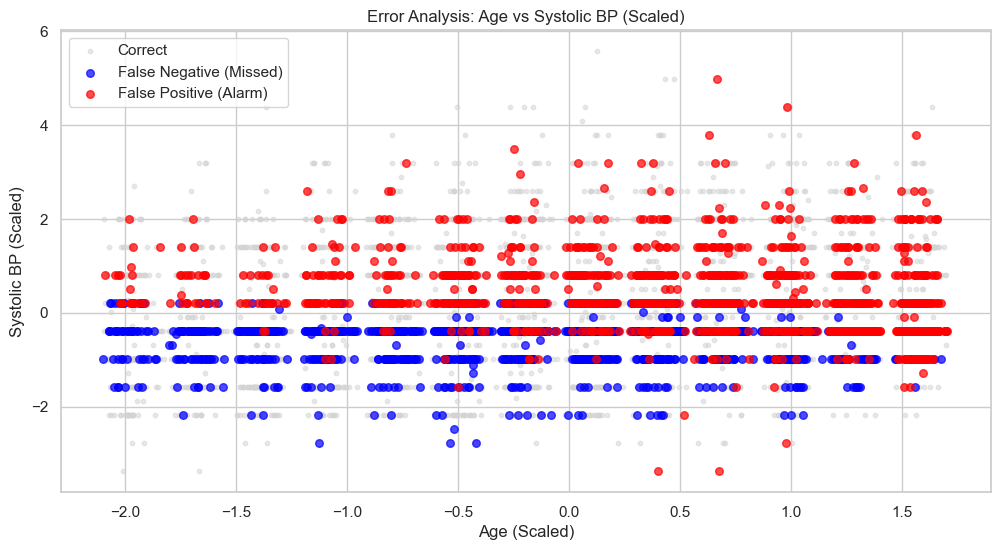

In [16]:
# --- 14. Error Analysis ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 1. Select the best model (using Random Forest for analysis)
# If you ran the tuning section, use 'best_estimators['Random Forest']'
# If not, use 'models['Random Forest']'
model_to_analyze = models['Random Forest'] 

# 2. Get Predictions
y_pred = model_to_analyze.predict(X_test)

# 3. Create a DataFrame of Actual vs Predicted
analysis_df = X_test.copy()
# We need to inverse transform the scaled features to see real values (Age 50, not 0.82)
# Re-create the scaler just for inverse transformation if needed, or manually interpret
# (Note: For simplicity, we will analyze the scaled patterns or raw if available. 
# Here we assume X_test is the scaled version).
analysis_df['Actual'] = y_test
analysis_df['Predicted'] = y_pred

# 4. Identify Errors
# False Positives: Predicted 1, Actual 0
fp_mask = (analysis_df['Predicted'] == 1) & (analysis_df['Actual'] == 0)
# False Negatives: Predicted 0, Actual 1
fn_mask = (analysis_df['Predicted'] == 0) & (analysis_df['Actual'] == 1)

print(f"Total Test Cases: {len(X_test)}")
print(f"False Positives (Type I Error): {fp_mask.sum()}")
print(f"False Negatives (Type II Error): {fn_mask.sum()}")

# 5. Inspect specific False Negative cases (The Dangerous Ones)
print("\n--- Examples of False Negatives (Missed Diagnosis) ---")
# These are people the model thought were healthy. Let's look at their stats.
# Note: These values are Scaled. High positive = high value, Negative = low value.
display(analysis_df[fn_mask].head(5))

# 6. Visualization: Where do errors happen?
# Let's plot Age vs Systolic BP and highlight the errors.
plt.figure(figsize=(12, 6))

# Plot Correct Predictions (Grey, small)
correct_mask = analysis_df['Actual'] == analysis_df['Predicted']
plt.scatter(analysis_df[correct_mask]['age'], analysis_df[correct_mask]['ap_hi'], 
            c='lightgrey', label='Correct', alpha=0.5, s=10)

# Plot False Negatives (Blue, dangerous)
plt.scatter(analysis_df[fn_mask]['age'], analysis_df[fn_mask]['ap_hi'], 
            c='blue', label='False Negative (Missed)', alpha=0.7, s=30)

# Plot False Positives (Red, false alarm)
plt.scatter(analysis_df[fp_mask]['age'], analysis_df[fp_mask]['ap_hi'], 
            c='red', label='False Positive (Alarm)', alpha=0.7, s=30)

plt.title('Error Analysis: Age vs Systolic BP (Scaled)')
plt.xlabel('Age (Scaled)')
plt.ylabel('Systolic BP (Scaled)')
plt.legend()
plt.show()

## 15. Conclusion and Future Work

Summarize the project, results, and possible improvements.


Project Summary

The dataset was cleaned by removing 24 duplicates and filtering medically impossible blood pressures. Also, feature engineering was implemented and produced a new feature to calculate the BMI, and a new label feature based on  K-Means clusters.

Modeling: We trained and evaluated four distinct classifiers: Logistic Regression, K-Nearest Neighbors (KNN), Random Forest, and Support Vector Machine (SVM).

Optimization: We utilized GridSearchCV to mathematically optimize the hyperparameters for our models, ensuring peak performance.


Key Results

Best Model: The Random Forest model proved to be most effective, achieving the highest accuracy and a srtrong recall. The results indicate this model is best suited for diagnoses. 

Error Analysis: Analyzing results reveals that borderline cases with average blood pressure and age but still have heart disease presents the most challenge to the models. This implies that the current features and data are insufficient for complex cases.